In [1]:
from tempfile import NamedTemporaryFile
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
# Import all of our packages
import numpy as np
#import prettytensor as pt

import matplotlib.pyplot as plt
import IPython.display
import math
from tqdm import tqdm # making loops prettier
import h5py # for reading our dataset
#import ipywidgets as widgets
#from ipywidgets import interact, interactive, fixed
import seaborn as sns
import pandas as pd
from glob import glob

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib.framework import arg_scope
from tensorflow.contrib import layers

plt.style.use('dark_background')
%matplotlib inline  

## Parameters 


In [3]:
dim1 = 32 # first dimension of input data
dim2 = 32 # second dimension of input data
dim3 = 1 # third dimension of input data (colors)
batch_size = 32 # size of batches to use (per GPU)
hidden_size = 2 # size of hidden (z) layer to use
num_examples = 1000 # how many examples are in your training set
num_epochs = 10000 # number of epochs to run
### we can train our different networks  with different learning rates if we want to

### Which GPUs are we using?
- Set `gpus` to a list of the GPUs you're using. The network will then split up the work between those gpus

In [4]:
import os

gpus = [0] # Here I set CUDA to only see one GPU
os.environ["CUDA_VISIBLE_DEVICES"]=','.join([str(i) for i in gpus])
num_gpus = len(gpus) # number of GPUs to use
if len(gpus) < 1:
    num_gpus = 1 

### Reading the dataset from HDF5 format
- open `makedataset.ipynb' for instructions on how to build the dataset

In [5]:
#search_directory = '/mnt/cube/tsainbur/github_repos/ModelComparisonProject/data/HDF5_of_syllable_specs/*_logscale_Feb24.hdf5'
search_directory = '/mnt/cube/tsainbur/github_repos/Starling_LS/data/HDF5_of_syllable_specs/*.hdf5'

In [6]:
#search_directory = '../data/HDF5_of_syllable_specs/*_syllables_silence.hdf5'
syllable_folders = glob(search_directory)
#syllable_folders = [syllable_folders[6]]
syllable_folders

['/mnt/cube/tsainbur/github_repos/Starling_LS/data/HDF5_of_syllable_specs/B336_OSL.hdf5',
 '/mnt/cube/tsainbur/github_repos/Starling_LS/data/HDF5_of_syllable_specs/b1174_Zeke.hdf5',
 '/mnt/cube/tsainbur/github_repos/Starling_LS/data/HDF5_of_syllable_specs/B337_OSL.hdf5',
 '/mnt/cube/tsainbur/github_repos/Starling_LS/data/HDF5_of_syllable_specs/B338_OSL.hdf5',
 '/mnt/cube/tsainbur/github_repos/Starling_LS/data/HDF5_of_syllable_specs/b1080_Zeke.hdf5',
 '/mnt/cube/tsainbur/github_repos/Starling_LS/data/HDF5_of_syllable_specs/b1114_zPhys.hdf5',
 '/mnt/cube/tsainbur/github_repos/Starling_LS/data/HDF5_of_syllable_specs/B165_OSL.hdf5',
 '/mnt/cube/tsainbur/github_repos/Starling_LS/data/HDF5_of_syllable_specs/b1094_Zeke.hdf5',
 '/mnt/cube/tsainbur/github_repos/Starling_LS/data/HDF5_of_syllable_specs/b1201_Zeke.hdf5',
 '/mnt/cube/tsainbur/github_repos/Starling_LS/data/HDF5_of_syllable_specs/B211_OSL.hdf5',
 '/mnt/cube/tsainbur/github_repos/Starling_LS/data/HDF5_of_syllable_specs/B335_OSL.hdf5',

In [7]:
all_names = []
for i, folder in enumerate(syllable_folders[::-1]):
   
    if i == 0:
        with h5py.File(folder,'r') as hf:
            for name in hf:
                print((hf[name]))
            spectrograms = hf['spectrograms'].value
            syll_lengths = hf['lengths'].value

            syll_start_time = hf['start'].value
            print((list(hf.attrs.values())[0], np.shape(hf['spectrograms'].value)))
            all_names.append(np.repeat(list(hf.attrs.values())[0], len(spectrograms)))
            wav_files = hf['wav_file'].value
            syll_start_rel_wav = hf['syll_start_rel_wav'].value
    else:
        with h5py.File(folder,'r') as hf:
            print(folder)
            #for name in hf:
            #    print(hf[name])
            if len(hf['spectrograms'].value) > 0:
                print(folder)
                spectrograms = np.concatenate((spectrograms,hf['spectrograms'].value))
                syll_lengths = np.concatenate((syll_lengths,hf['lengths'].value))
                syll_start_time = np.concatenate((syll_start_time,hf['start'].value))
                syll_start_rel_wav = np.concatenate((syll_start_rel_wav,hf['syll_start_rel_wav'].value))
                wav_files = np.concatenate((wav_files,hf['wav_file'].value))
                print((list(hf.attrs.values())[0], np.shape(hf['spectrograms'].value)))
                all_names.append(np.repeat(list(hf.attrs.values())[0], np.shape(hf['spectrograms'].value)[0]))

<HDF5 dataset "lengths": shape (6913,), type "<f4">
<HDF5 dataset "spectrograms": shape (6913, 32, 32), type "|u1">
<HDF5 dataset "start": shape (6913, 1), type "|O">
<HDF5 dataset "syll_start_rel_wav": shape (6913,), type "<f4">
<HDF5 dataset "wav_file": shape (6913, 1), type "|O">
('b1114_Zeke', (6913, 32, 32))
/mnt/cube/tsainbur/github_repos/Starling_LS/data/HDF5_of_syllable_specs/b1074_Zeke.hdf5
/mnt/cube/tsainbur/github_repos/Starling_LS/data/HDF5_of_syllable_specs/b1074_Zeke.hdf5
('b1074_Zeke', (14287, 32, 32))
/mnt/cube/tsainbur/github_repos/Starling_LS/data/HDF5_of_syllable_specs/B335_OSL.hdf5
/mnt/cube/tsainbur/github_repos/Starling_LS/data/HDF5_of_syllable_specs/B335_OSL.hdf5
('B335_OSL', (59370, 32, 32))
/mnt/cube/tsainbur/github_repos/Starling_LS/data/HDF5_of_syllable_specs/B211_OSL.hdf5
/mnt/cube/tsainbur/github_repos/Starling_LS/data/HDF5_of_syllable_specs/B211_OSL.hdf5
('B211_OSL', (3867, 32, 32))
/mnt/cube/tsainbur/github_repos/Starling_LS/data/HDF5_of_syllable_specs/b1

In [8]:
np.shape(spectrograms)

(247059, 32, 32)

In [9]:
# remove nans from dataset
print(np.shape(spectrograms))
nan_specs = np.isnan(spectrograms).any(axis=1).any(axis=1)
spectrograms = spectrograms[~nan_specs]
syll_start_time = syll_start_time[~nan_specs]
all_names = np.concatenate(all_names)[~nan_specs]
syll_lengths = syll_lengths[~nan_specs]
syll_start_rel_wav = syll_start_rel_wav[~nan_specs]
wav_files = wav_files[~nan_specs]

print(np.shape(spectrograms))

(247059, 32, 32)
(247059, 32, 32)


In [10]:
# reshape dataset
spectrograms = np.reshape(spectrograms,(len(spectrograms), dim1,dim2))

In [11]:
spectrograms = spectrograms.astype('float32')

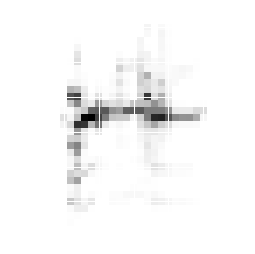

In [12]:
plt.matshow(spectrograms[0])

In [13]:
print(np.max(spectrograms), np.min(spectrograms), np.mean(spectrograms))

(255.0, 0.0, 35.605499)


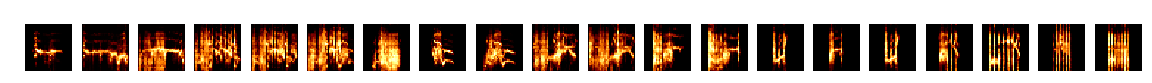

In [14]:
fig, ax = plt.subplots(nrows=1,ncols=20, figsize=(20,1))
for i in range(20):
    ax[i].matshow(spectrograms[i], cmap=plt.cm.afmhot, interpolation='nearest', origin='lower')
    ax[i].axis('off')

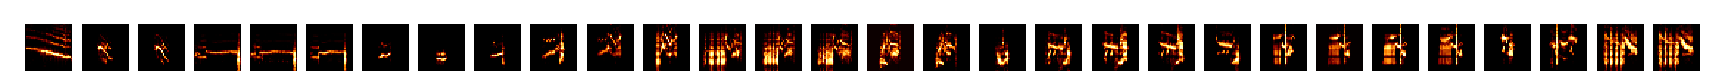

In [15]:
test2 = spectrograms[np.squeeze(np.array([wav_files == '/mnt/lintu/home/Gentnerlab/share/stimuli/OneStimLibraryToRuleThemAll/B165/RawSong/165_s_03.wav']))]
nex = 30
fig, ax = plt.subplots(nrows=1, ncols=nex, figsize=(nex,1))
for i in range(nex):
    ax[i].matshow(test2[i], cmap=plt.cm.afmhot, interpolation='nearest', origin='lower')
    ax[i].axis('off')


In [16]:
# make sure everything is 0-1 normalized
spectrograms = (spectrograms - np.apply_over_axes(np.min,spectrograms, [1,2])) / \
    (np.apply_over_axes(np.max,spectrograms, [1,2]) - np.apply_over_axes(np.min,spectrograms, [1,2]))

In [17]:
np.max(spectrograms)

1.0

In [18]:
np.min(spectrograms)

0.0

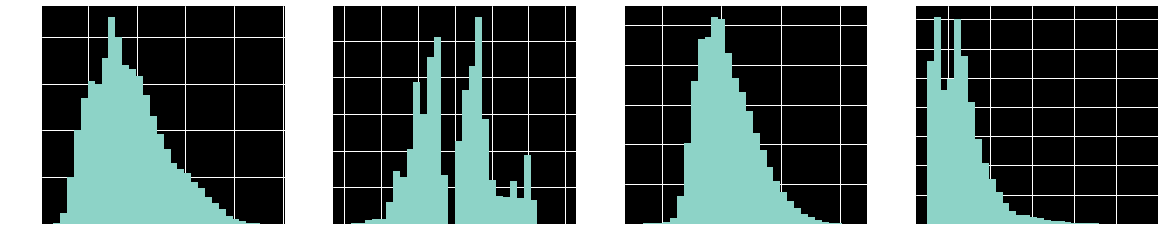

In [19]:
fig, ax = plt.subplots(nrows=1,ncols=4, figsize=(20,4))
_ = ax[0].hist(np.max(np.sum(spectrograms, axis = 2),axis=1), bins=32)
_ = ax[1].hist(np.argmax(np.sum(spectrograms, axis = 2),axis=1), bins=32)
_ = ax[2].hist(np.max(np.sum(spectrograms, axis = 2),axis=1)*.75 -
             np.sum(spectrograms, axis = 2)[:,0]
             , bins=32)
_ = ax[3].hist(syll_lengths, bins=32)

In [20]:
num_examples = len(spectrograms)
num_examples

247059

In [21]:
np.mean(syll_lengths)

0.64265752

In [22]:
# grab the faces back out after we've flattened them
def create_image(im):
    return np.reshape(im,(dim1,dim2))

### A data iterator for batching (drawn up by Luke Metz)
- https://indico.io/blog/tensorflow-data-inputs-part1-placeholders-protobufs-queues/


In [23]:
def data_iterator():
    """ A simple data iterator """
    batch_idx = 0
    while True:
        idxs = np.arange(0, len(spectrograms))
        np.random.shuffle(idxs)
        for batch_idx in range(0, len(spectrograms), batch_size*num_gpus):
            cur_idxs = idxs[batch_idx:batch_idx+batch_size*num_gpus]
            images_batch = spectrograms[cur_idxs]
            time_batch = syll_start_time[cur_idxs]
            names_batch = all_names[cur_idxs]
            syll_lengths_batch = syll_lengths[cur_idxs]
            syll_start_rel_wav_batch = syll_start_rel_wav[cur_idxs]
            wav_files_batch = wav_files[cur_idxs]

            yield images_batch.reshape((batch_size*num_gpus, dim1*dim2*dim3)), time_batch, \
                names_batch, syll_lengths_batch, syll_start_rel_wav_batch, wav_files_batch

            
iter_ = data_iterator()

In [24]:
ex_data, _, _, _,_,_ = iter_.next()

In [25]:
ex_data.shape

(32, 1024)

In [26]:
def shape(tensor):
    s = tensor.get_shape()
    return tuple([s[i].value for i in range(0, len(s))])

In [27]:
math.sqrt(4000)

63.245553203367585

In [28]:
def encoder(X):
    '''Create encoder network.
    Args:
        x: a batch of flattened images [batch_size, 28*28]
    Returns:
        A tensor that expresses the encoder network
            # The transformation is parametrized and can be learned.
            # returns network output, mean, setd
    '''
    net = tf.reshape(X, [batch_size, dim1, dim2, dim3])
    net = layers.conv2d(net, 32, 5, stride=2)
    net = layers.conv2d(net, 64, 5, stride=2)
    net = layers.conv2d(net, 128, 5, stride=2)
    net= layers.conv2d(net, 256, 5, stride=2)
    net =  layers.flatten(net)
    net = layers.fully_connected(net, 4000)
    net = layers.fully_connected(net, 4000)
    net = layers.fully_connected(net, hidden_size, activation_fn=None)
    #print('Encoder shapes: ', shape(net), shape(l1), shape(l2), shape(l3), shape(l4))
    
    return net




def generator(Z):
    '''Create generator network.
        If input tensor is provided then decodes it, otherwise samples from 
        a sampled vector.
    Args:
        x: a batch of vectors to decode
    Returns:
        A tensor that expresses the generator network
    '''
    
    
    net = layers.fully_connected(Z, 4000)
    net = layers.fully_connected(net, 4000)
    net = tf.reshape(layers.fully_connected(net, 4*4*256), [batch_size, 4,4,256])
    net = tf.image.resize_nearest_neighbor(net, (8,8))
    net = layers.conv2d(net, 256, 5, stride=1)
    net = tf.image.resize_nearest_neighbor(net, (16,16))
    net = layers.conv2d(net, 128, 5, stride=1)
    net = tf.image.resize_nearest_neighbor(net, (32,32))
    net = layers.conv2d(net, 32, 5, stride=1)
    net = layers.conv2d(net, dim3, 1, stride=1, activation_fn=tf.sigmoid)
    net = layers.flatten(net)
    
    #print('Decoder shapes: ', (shape(l1), shape(l2), shape(l3), shape(l4), shape(l5a)))
    return net#l1,l2,l3,l5a
           

#('Encoder shapes: ', (32, 16, 16, 32), (32, 8, 8, 64), (32, 4, 4, 128), (32, 2, 2, 256))
#Decoder shapes:  ((32, 2, 2, 256), (32, 4, 4, 128), (32, 16, 16, 32), (32, 1024))

### Defining the forward pass through the network
- This function is based upon the inference function from tensorflows cifar tutorials
  - https://github.com/tensorflow/tensorflow/blob/r0.10/tensorflow/models/image/cifar10/cifar10.py
- Notice I use `with tf.variable_scope("enc")`. This way, we can reuse these variables using `reuse=True`. We can also specify which variables to train using which error functions based upon the label `enc`

In [29]:
def inference(x):
    """
    Run the models. Called inference because it does the same thing as tensorflow's cifar tutorial
    """
    z_p =  tf.random_normal((batch_size, hidden_size), 0, 1) # normal dist for GAN

    with arg_scope([layers.fully_connected, layers.conv2d], activation_fn=tf.nn.relu):
        
        with tf.variable_scope("enc"):         
                z_x = encoder(x) # get z from the input      
        with tf.variable_scope("gen"):
            x_tilde = generator(z_x)  
            
    return z_x, x_tilde

### Loss - define our various loss functions
- **SSE** - we don't actually use this loss (also its the MSE), its just to see how close x is to x_tilde
- **KL Loss** - our VAE gaussian distribution loss. 
  - See https://arxiv.org/abs/1312.6114
- **D_loss** - Our descriminator loss, how good the discriminator is at telling if something is real
- **G_loss** - essentially the opposite of the D_loss, how good the generator is a tricking the discriminator
- ***notice we clip our values to make sure learning rates don't explode***

In [30]:
def squared_dist(A): 
    #http://stackoverflow.com/questions/37009647/compute-pairwise-distance-in-a-batch-without-replicating-tensor-in-tensorflow
    expanded_a = tf.expand_dims(A, 1)
    expanded_b = tf.expand_dims(A, 0)
    distances = tf.reduce_sum(tf.squared_difference(expanded_a, expanded_b), 2)
    return distances

def loss(x, x_tilde, z_x):
    """
    Loss functions for SSE, KL divergence, Discrim, Generator, Lth Layer Similarity
    """
    ### We don't actually use SSE (MSE) loss for anything (but maybe pretraining)
    SSE_loss = tf.reduce_mean(tf.square(x - x_tilde)) # This is what a normal VAE uses
    #sdx = squared_dist(x)
    #sdx = sdx/tf.reduce_mean(sdx)
    #sdz = squared_dist(z_x)
    #sdz = sdz/tf.reduce_mean(sdz)
    #distance_loss =  tf.reduce_mean(tf.square(tf.log(tf.constant(1.)+sdx) - (tf.log(tf.constant(1.)+sdz))))

    return SSE_loss#, distance_loss

### Average the gradients between towers
- This function is taken directly from 
    - https://github.com/tensorflow/tensorflow/blob/r0.10/tensorflow/models/image/cifar10/cifar10_multi_gpu_train.py
- Basically we're taking a list of gradients from each tower, and averaging them together

In [31]:
def average_gradients(tower_grads):
    """Calculate the average gradient for each shared variable across all towers.
    Note that this function provides a synchronization point across all towers.
    Args:
    tower_grads: List of lists of (gradient, variable) tuples. The outer list
      is over individual gradients. The inner list is over the gradient
      calculation for each tower.
    Returns:
     List of pairs of (gradient, variable) where the gradient has been averaged
     across all towers.
     
     
    """
    average_grads = []
    for grad_and_vars in zip(*tower_grads):
        # Note that each grad_and_vars looks like the following:
        #   ((grad0_gpu0, var0_gpu0), ... , (grad0_gpuN, var0_gpuN))
        grads = []
        for g, _ in grad_and_vars:
            # Add 0 dimension to the gradients to represent the tower.
            expanded_g = tf.expand_dims(g, 0)

            # Append on a 'tower' dimension which we will average over below.
            grads.append(expanded_g)

        # Average over the 'tower' dimension.
        grad = tf.concat(grads, 0)
        grad = tf.reduce_mean(grad, 0)

        # Keep in mind that the Variables are redundant because they are shared
        # across towers. So .. we will just return the first tower's pointer to
        # the Variable.
        v = grad_and_vars[0][1]
        grad_and_var = (grad, v)
        average_grads.append(grad_and_var)
    return average_grads


### Plot network output
- This is just my ugly function to regularly plot the output of my network - tensorboard would probably be a better option for this

In [32]:
graph = tf.Graph()

### With your graph, define what a step is (needed for multi-gpu), and what your optimizers are for each of your networks

In [33]:
with graph.as_default():
    #with tf.Graph().as_default(), tf.device('/cpu:0'):
    # Create a variable to count number of train calls
    global_step = tf.get_variable(
        'global_step', [],
        initializer=tf.constant_initializer(0), trainable=False)


    # different optimizers are needed for different learning rates (using the same learning rate seems to work fine though)
    lr_G = tf.placeholder(tf.float32, shape=[])
    lr_E = tf.placeholder(tf.float32, shape=[])
    opt_G = tf.train.AdamOptimizer(lr_G, epsilon=1.0)
    opt_E = tf.train.AdamOptimizer(lr_E, epsilon=1.0)
    

### Run all of the functions we defined above
- `tower_grads_e` defines the list of gradients for the encoder for each tower
- For each GPU we grab parameters corresponding to each network, we then calculate the gradients, and add them to the twoers to be averaged


In [34]:
with graph.as_default():

    # These are the lists of gradients for each tower 
    tower_grads_e = []
    tower_grads_g = []

    all_input = tf.placeholder(tf.float32, [batch_size*num_gpus, dim1*dim2*dim3])
    E_param = tf.placeholder(tf.float32)
    G_param = tf.placeholder(tf.float32)
    #dist_param = tf.placeholder(tf.float32)

    with tf.variable_scope(tf.get_variable_scope()):
        # Define the network for each GPU
        for i in range(num_gpus):
              with tf.device('/cpu:%d' % i):
                    with tf.name_scope('Tower_%d' % (i)) as scope:
                        # grab this portion of the input
                        next_batch = all_input[i*batch_size:(i+1)*batch_size,:]

                        # Construct the model
                        z_x, x_tilde = inference(next_batch)

                        # Calculate the loss for this tower   
                        SSE_loss = loss(next_batch, x_tilde, z_x)

                        # specify loss to parameters
                        params = tf.trainable_variables()
                        E_params = [i for i in params if 'enc' in i.name]
                        G_params = [i for i in params if 'gen' in i.name]

                        # Calculate the losses specific to encoder, generator, decoder
                        L_e = tf.clip_by_value(E_param*SSE_loss, -100, 100)
                        L_g = tf.clip_by_value(G_param*SSE_loss, -100, 100)

                        # Reuse variables for the next tower.
                        tf.get_variable_scope().reuse_variables()

                        # Calculate the gradients for the batch of data on this CIFAR tower.
                        grads_e = opt_E.compute_gradients(L_e, var_list = E_params)
                        grads_g = opt_G.compute_gradients(L_g, var_list = G_params)

                        # Keep track of the gradients across all towers.
                        tower_grads_e.append(grads_e)
                        tower_grads_g.append(grads_g)


### Now lets average, and apply those gradients

In [35]:
with graph.as_default():
    # Average the gradients
    grads_e = average_gradients(tower_grads_e)
    grads_g = average_gradients(tower_grads_g)

    # apply the gradients with our optimizers
    train_E = opt_E.apply_gradients(grads_e, global_step=global_step)
    train_G = opt_G.apply_gradients(grads_g, global_step=global_step)

In [36]:
opt_E

### Now lets actually run our session

In [37]:
with graph.as_default():

    # Start the Session
    init = tf.global_variables_initializer()
    sess = tf.InteractiveSession(graph=graph,config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))
    sess.run(init)
    saver = tf.train.Saver() # initialize network saver


### Get some example data to do visualizations with

In [39]:
example_data, _, _, _, _, _= iter_.next()
np.shape(example_data)

(32, 1024)

### Initialize our epoch number, and restore a saved network by uncommening `#tf.train...`

In [40]:
epoch = 0
#tf.train.Saver.restore(saver, sess, 'models/All_Starling_Dec2016.tfmod')

### Now we actually run the network
- Importantly, notice how we define the learning rates 
    - `e_current_lr = e_learning_rate*sigmoid(np.mean(d_real),-.5,10)`
        - we calculate the sigmoid of how the network has been performing, and squash the learning rate using a sigmoid based on that. So if the discriminator has been winning, it's learning rate will be low, and if the generator is winning, it's learning rate will be lower on the next batch.

In [41]:
def plot_network_output():
    """ Just plots the output of the network, error, reconstructions, etc
    """
    examples = 8
    recon_x = sess.run((x_tilde), {all_input: example_data})

    recon_x = np.squeeze(recon_x)
    
    fig, ax = plt.subplots(nrows=2,ncols=examples, figsize=(18,5))
    for i in xrange(examples):
        ax[(0,i)].matshow(create_image(recon_x[i]), cmap=plt.cm.afmhot, interpolation='nearest', origin='lower')
        ax[(1,i)].matshow(create_image(example_data[i + (num_gpus-1)*batch_size]), cmap=plt.cm.afmhot,
                          interpolation='nearest', origin='lower')
        ax[(0,i)].axis('off')
        ax[(1,i)].axis('off')
    plt.show()
    if len(SSE_loss_list) > 100:
        SSE_plt, = plt.loglog((SSE_loss_list),linewidth = 4,ls='-', color='g',alpha = .5, label='SSE')
        SSE_plt, = plt.loglog((dist_loss_list),linewidth = 4,ls='-', color='b',alpha = .5, label='dist')
    axes = plt.gca()
    plt.show()
    

Epoch: 0


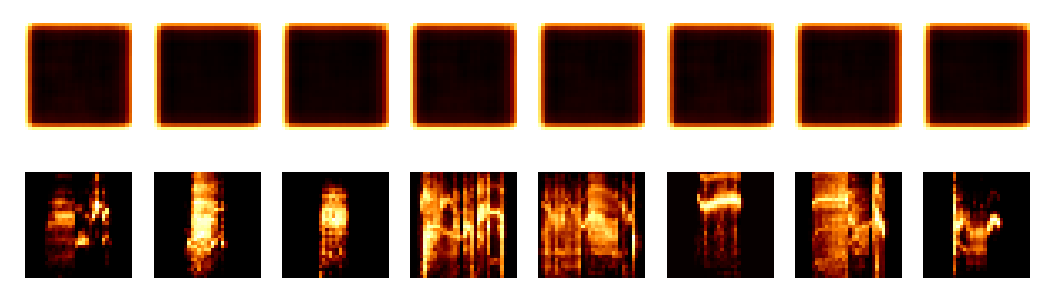

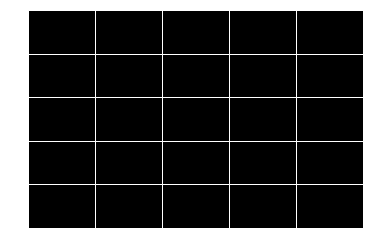

  2%|▏         | 130/7720 [03:36<3:31:06,  1.67s/it]

KeyboardInterrupt: 

In [42]:
%matplotlib inline
total_batch = int(np.floor(num_examples / batch_size/num_gpus)) # how many batches are in an epoch

# We balance of generator and discriminators learning rate by using a sigmoid function,
#  encouraging the generator and discriminator be about equal

SSE_loss_list = []
dist_loss_list = []


while epoch < num_epochs: 
   
    e_current_lr = 1.0
    g_current_lr = 1.0

    iter_ = data_iterator()
    for i in tqdm(range(total_batch)):
        # balence gen and descrim  
        next_batches, _, _, _, _, _ = iter_.next()

        _, _,SSE_err = sess.run([
                train_E, train_G,
                SSE_loss#, distance_loss
            ],
                                        {
                all_input: next_batches,
                G_param: 1.,
                E_param: 1.,
                #dist_param: 0.0,#1.0e-1,
                lr_E: e_current_lr,
                lr_G: g_current_lr
            }
       )
        #print SSE_err, dist_err
        SSE_loss_list.append(SSE_err)    
        #dist_loss_list.append(dist_err)    
        if i%1000 == 0:
            # print display network output
            IPython.display.clear_output()
            print('Epoch: '+str(epoch))
            plot_network_output()

    # save network
    #if epoch%10 == 0:
    #saver.save(sess,''.join(['models/birdsong_mel32',str(epoch).zfill(4),'.tfmod']))
    epoch +=1


In [ ]:
#saver.save(sess,''.join(['../data/Models/All_Starling_May012017.ffmod']))

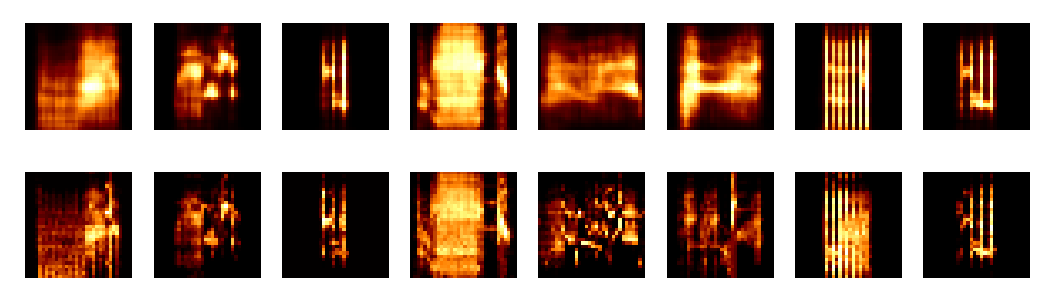

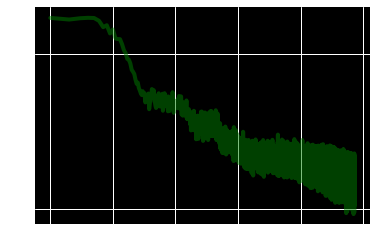

In [43]:
plot_network_output()

In [44]:
def generate_manifold(total_batch, batch_size):
    recon_z = np.zeros((total_batch*batch_size,2))
    recon_time = np.array(np.zeros((total_batch*batch_size,)), dtype=object)
    recon_st_rel_wav = np.array(np.zeros((total_batch*batch_size,)), dtype=object)
    recon_wav_file = np.array(np.zeros((total_batch*batch_size,)), dtype=object)
    recon_length = np.zeros((total_batch*batch_size,))
    recon_name =  np.array(np.zeros((total_batch*batch_size,)), dtype=object)
    all_x = np.zeros((total_batch*batch_size,dim1*dim2))
    iter_ = data_iterator() 
    for i in tqdm(range(total_batch)):
        # balence gen and descrim
        next_batches, rt, rn,rl,strw,wf  = iter_.next()
        recon_time[i*batch_size:(i+1)*batch_size] = np.squeeze(rt)
        recon_st_rel_wav[i*batch_size:(i+1)*batch_size] = np.squeeze(strw)
        recon_wav_file[i*batch_size:(i+1)*batch_size] = np.squeeze(wf)
        recon_time[i*batch_size:(i+1)*batch_size] = np.squeeze(rt)
        recon_name[i*batch_size:(i+1)*batch_size] = np.squeeze(rn)
        recon_length[i*batch_size:(i+1)*batch_size] = np.squeeze(rl)
        all_x[i*batch_size:(i+1)*batch_size, :] = next_batches
        recon_z[i*batch_size:(i+1)*batch_size,:] = sess.run((z_x), {all_input: next_batches})
    return recon_z, recon_time, recon_length, recon_name, all_x, recon_st_rel_wav, recon_wav_file

In [46]:
recon_z, recon_time, recon_length, recon_name, all_x, st_rel_wav, wav_file  = generate_manifold(total_batch, batch_size)


 16%|█▌        | 1221/7720 [00:06<00:32, 200.08it/s]

 77%|███████▋  | 5909/7720 [00:30<00:09, 198.43it/s]


100%|██████████| 7720/7720 [00:39<00:00, 194.79it/s]

In [47]:
def log_scale_manifold(recon_z):
    radius = np.array([np.linalg.norm([0,0]-recon_z[i]) for i in range(len(recon_z))])
    recon_z_rt = recon_z / np.sqrt(radius)[:,None]
    recon_z_log = np.log2(radius)[:,None] / radius[:,None] * recon_z
    return recon_z_log, recon_z_rt
recon_z_log, recon_z_rt = log_scale_manifold(recon_z)

In [48]:
def plot_manifold(recon_z_log):
    fig, ax= plt.subplots(nrows=1,ncols=1,figsize=(18,18))
    ax.scatter(recon_z_log.T[0], recon_z_log.T[1],
               color='black', alpha = 0.25, linewidth= 0, s=1)
    ax.axis('off')

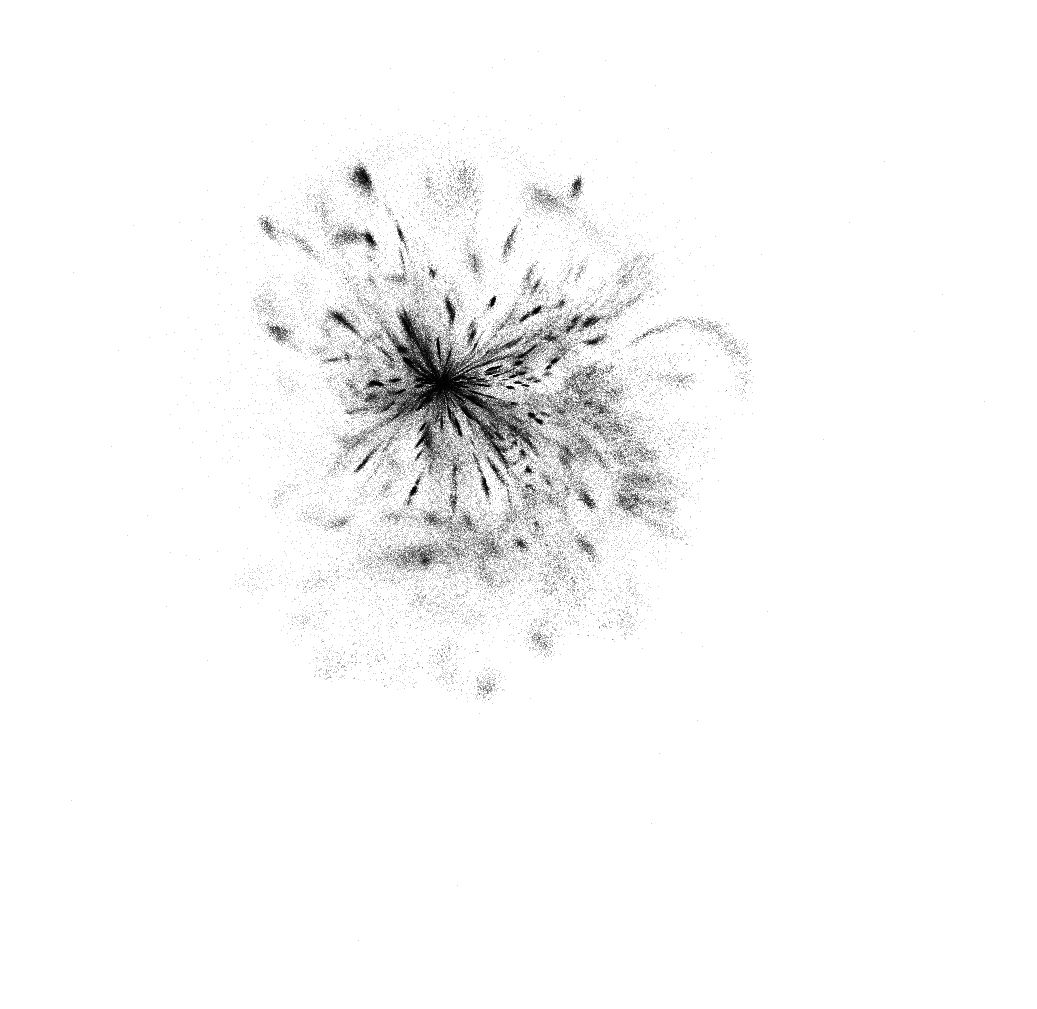

In [49]:
plot_manifold(recon_z_log)

In [ ]:
""np.savez('../data/2D_Projections/z_values_ST_test.npz',
         all_x = all_x, 
         recon_z = recon_z, 
         recon_time= recon_time, 
         labels= [], 
         recon_name=recon_name,
         recon_length = recon_length,
         start_time_rel_wav = st_rel_wav,
         wav_file = wav_file)""